In [1]:
# Imports.
import sys
sys.path.append(r'C:\Users\edova\Documents\GitLab\distortion-correction')
import naclib.stpol
import naclib.util
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Input; spots in df_locs0 are shifted towards spots in df_locs1, the latter remain static.
df_locs0 = pd.read_csv('../example/reference_locs_green.csv')
df_locs1 = pd.read_csv('../example/reference_locs_red.csv')
fig_size = [512, 256]  # Original image size, needed for rescaling to unit circle.
threshold = 5  # Nearest neighbour search threshold in pixels.
j_max_S = 28  # Max term for S polynomials.
j_max_T = 15  # Max term for T polynomials.

# Output
output_coefficients = '../example/STcoefficients.csv'

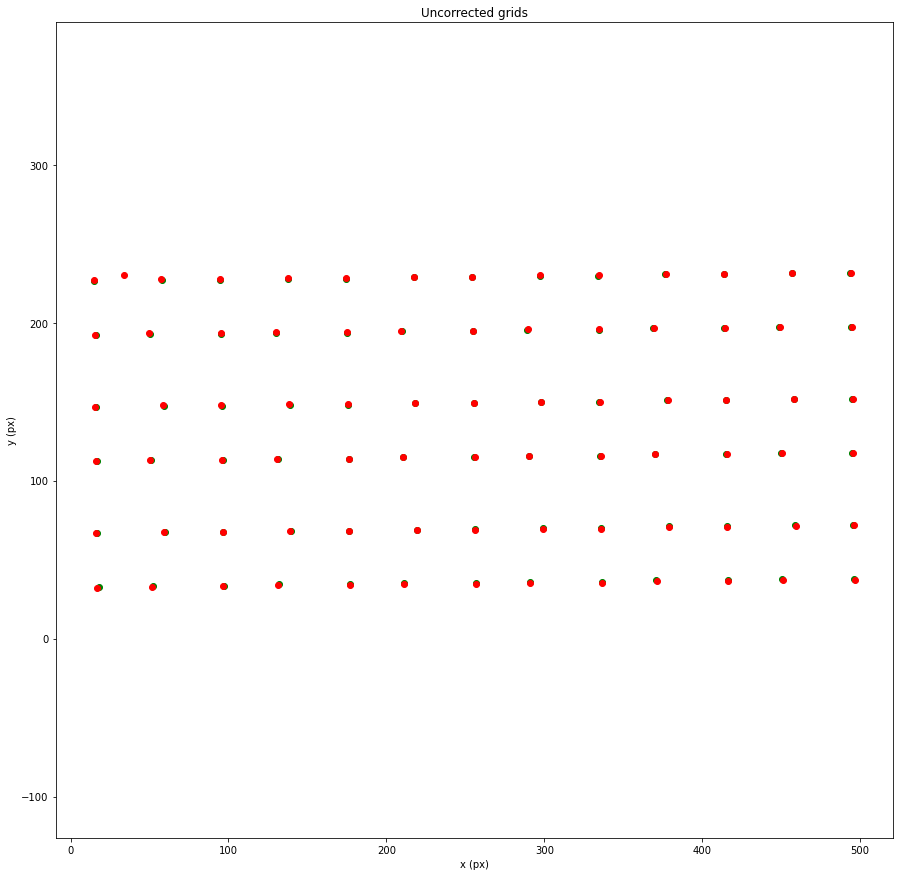

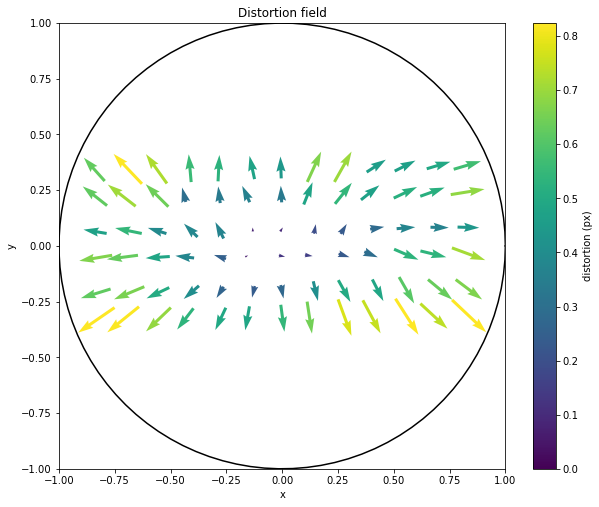

In [3]:
# Find spot pairs, by finding nearest neighbours between locs0 and locs1.
locs0_raw = np.zeros((len(df_locs0), 2))
locs0_raw[:, 0] = df_locs0['x']
locs0_raw[:, 1] = df_locs0['y']
locs1_raw = np.zeros((len(df_locs1), 2))
locs1_raw[:, 0] = df_locs1['x']
locs1_raw[:, 1] = df_locs1['y']

# Plot the original grids.
plt.figure(figsize=(15, 15))
plt.scatter(locs0_raw[:, 0], locs0_raw[:, 1], c='g')
plt.scatter(locs1_raw[:, 0], locs1_raw[:, 1], c='r')
plt.title('Uncorrected grids')
plt.xlabel('x (px)')
plt.ylabel('y (px)')
plt.axis('equal')
plt.show()

# Find the nearest neighbours; rescale to unit circle.
mapping = naclib.util.find_neighbours(locs0_raw, locs1_raw, threshold=threshold)
locs0_pairs, locs1_pairs = naclib.util.make_pairs(locs0_raw, locs1_raw, mapping)
locs0, scale = naclib.util.loc_to_unitcircle(locs0_pairs, fig_size)
locs1, scale = naclib.util.loc_to_unitcircle(locs1_pairs, fig_size)

# Get distortion grid.
D = np.zeros(locs0.shape)
D[:, 0] = locs1[:, 0] - locs0[:, 0]
D[:, 1] = locs1[:, 1] - locs0[:, 1]

# Plot distortion grid.
magnitude = np.hypot(D[:, 0], D[:, 1]) * scale
plt.figure(figsize=(10, 8.2))
q = plt.quiver(locs0[:, 0], locs0[:, 1], D[:, 0], D[:, 1], magnitude, pivot='mid', clim=(0, 1.2 * scale * np.amax(D)))
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), c='k')
clb = plt.colorbar(q)
plt.title('Distortion field')
plt.xlabel('x')
plt.ylabel('y')
clb.set_label('distortion (px)')
plt.axis('equal')
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.show()

In [4]:
# Get ST polynomial decomposition coefficients.
stpol = naclib.stpol.STPolynomials(j_max_S=j_max_S, j_max_T=j_max_T)
a_S, a_T = stpol.get_decomposition(locs0, D)

# Save resulting coefficients.
df_coefs = pd.DataFrame(columns=['type', 'term', 'value'])
for term, value in a_S.items():
    df_coefs = df_coefs.append({'type': 'S', 'term': term, 'value': value}, ignore_index=True)
for term, value in a_T.items():
    df_coefs = df_coefs.append({'type': 'T', 'term': term, 'value': value}, ignore_index=True)
df_coefs.to_csv(output_coefficients)

df_coefs

,type,term,value
0,S,1,0.000000
1,S,2,0.000096
2,S,3,-0.002295
3,S,4,0.006438
4,S,5,0.000286
5,S,6,-0.004702
6,S,7,-0.002771
7,S,8,-0.000474
8,S,9,0.001854
9,S,10,0.000496


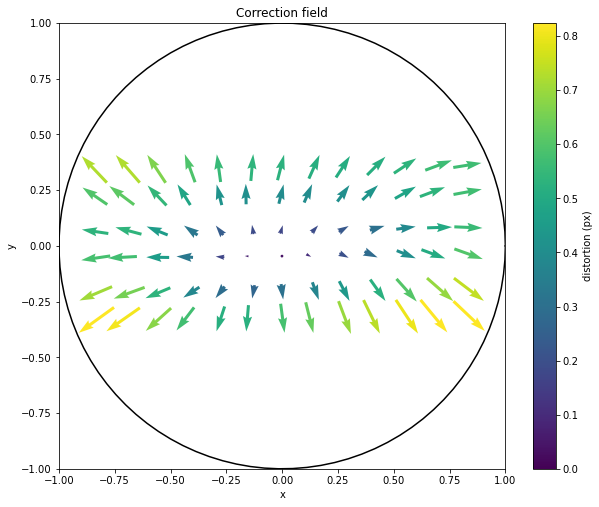

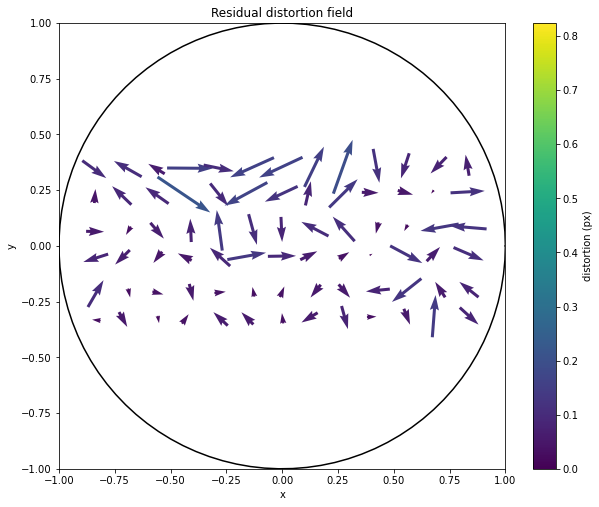

0.08435421458218813


In [5]:
# Show correction field.
P = stpol.get_field(locs0, a_S, a_T)
magnitude_P = np.hypot(P[:, 0], P[:, 1]) * scale
plt.figure(figsize=(10, 8.2))
q = plt.quiver(locs0[:, 0], locs0[:, 1], P[:, 0], P[:, 1], magnitude_P, 
               pivot='mid', clim=(0, 1.2 * scale * np.amax(D)))
clb = plt.colorbar(q)
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), c='k')
plt.title('Correction field')
plt.xlabel('x')
plt.ylabel('y')
clb.set_label('distortion (px)')
plt.axis('equal')
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.show()

# Show residual distortion grid.
locs0_corrected = locs0 + P
D_res = np.zeros(locs0_corrected.shape)
D_res[:, 0] = locs1[:, 0] - locs0_corrected[:, 0]
D_res[:, 1] = locs1[:, 1] - locs0_corrected[:, 1]
magnitude_res = np.hypot(D_res[:, 0], D_res[:, 1]) * scale
plt.figure(figsize=(10, 8.2))
q = plt.quiver(locs0[:, 0], locs0[:, 1], D_res[:, 0], D_res[:, 1], magnitude_res, 
               pivot='mid', clim=(0, 1.2 * scale * np.amax(D)))
clb = plt.colorbar(q)
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), c='k')
plt.title('Residual distortion field')
plt.xlabel('x')
plt.ylabel('y')
clb.set_label('distortion (px)')
plt.axis('equal')
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.show()

print(np.mean(magnitude_res))